In [12]:
import numpy as np
import pandas as pd
import os
import imageio
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import matthews_corrcoef, f1_score

# Ensemble France predictions

## Han and Burak's samples

In [30]:
splits_df = pd.read_csv('../data/splits/hanAndBurak_planetImagery_splits.csv')

In [23]:
months = ['january', 'april', 'october']
pred_names = os.listdir('../results/france/hanAndBurak/resunet-d7_october_nfilter-32_bs-8_lr-0.001/extent_predictions/')
all_preds_extent = {}
all_preds_bound = {}

for month in months:
    results_dir = '../results/france/hanAndBurak/resunet-d7_{}_nfilter-32_bs-8_lr-0.001/'.format(month)
    extent_dir = os.path.join(results_dir, 'extent_predictions')
    bound_dir = os.path.join(results_dir, 'boundary_predictions')

    all_preds_extent[month] = np.zeros((len(pred_names), 256, 256))
    all_preds_bound[month] = np.zeros((len(pred_names), 256, 256))
    
    for i, pred_name in enumerate(pred_names):
        all_preds_extent[month][i] = np.load(os.path.join(extent_dir, pred_name))
        all_preds_bound[month][i] = np.load(os.path.join(bound_dir, pred_name))

### Average consensus

In [26]:
# take difference of each month's extent and boundary predictions
consensus = np.zeros((len(pred_names), 256, 256))

for i in range(len(pred_names)):
    for month in months:
        consensus[i] += all_preds_extent[month][i]
        consensus[i] -= all_preds_bound[month][i]

consensus = np.maximum(consensus,0) / 3.

#### Subtracting boundary from extent

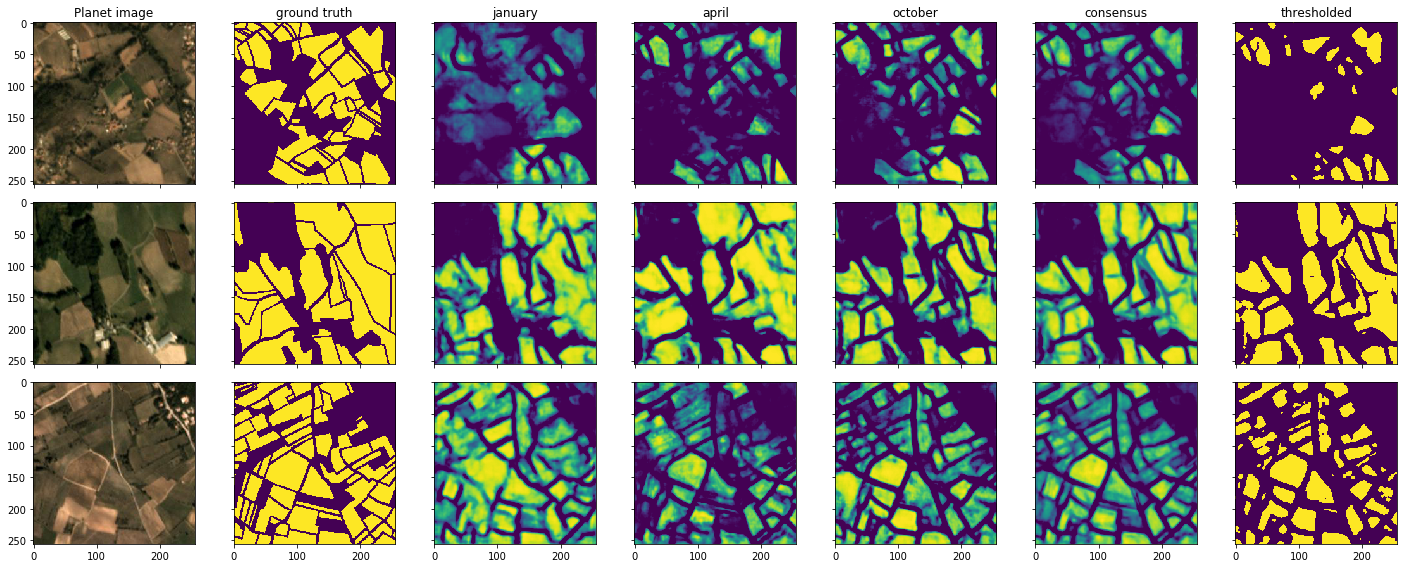

In [60]:
# threshold consensus and plot
thresholded = consensus >= 0.5

n_samples = 3
np.random.seed(0)
random_samples = np.random.choice(np.arange(0, len(pred_names)), n_samples, replace=False)

fig, ax = plt.subplots(n_samples, 7, figsize=(20, 8), sharex=True, sharey=True)
for r, idx in enumerate(random_samples):
    img_name = pred_names[idx].split('.')[0]
    img = imageio.imread(
        '../data/planet/france/hanBurak2k/october_256x256/{}.jpeg'.format(img_name))
    ax[r,0].imshow(img)
    
    extent_true = imageio.imread('../data/planet/france/hanBurak2k/labels_256x256/{}.png'.format(img_name))
    ax[r,1].imshow(extent_true)
    
    for c, month in enumerate(months):
        ax[r,c+2].imshow(np.maximum(all_preds_extent[month][idx] - all_preds_bound[month][idx], 0))
        if r == 0:
            ax[r,c+2].set_title(month)
            
    ax[r,5].imshow(consensus[idx])
    ax[r,6].imshow(thresholded[idx])
    
    if r == 0:
        ax[r,0].set_title('Planet image')
        ax[r,1].set_title('ground truth')
        ax[r,5].set_title('consensus')
        ax[r,6].set_title('thresholded')
    
plt.tight_layout()
plt.show()

In [40]:
# metrics
f1s = []
mccs = []
for i, name in enumerate(pred_names):
    image_id = name.split('.')[0]
    extent_true = imageio.imread('../data/planet/france/hanBurak2k/labels_256x256/{}.png'.format(image_id))
    
    y_true = np.array(extent_true / 255., dtype=np.uint8).flatten()
    y_pred = thresholded[i].astype(np.uint8).flatten()
    f1 = f1_score(y_true, y_pred)
    f1s.append(f1)
    mcc = matthews_corrcoef(y_true, y_pred)
    mccs.append(mcc)

/home/swang222/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/swang222/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [50]:
# metrics
f1s = []
mccs = []
all_extent_true = np.zeros((len(pred_names), 256, 256))

for i, name in enumerate(pred_names):
    image_id = name.split('.')[0]
    extent_true = imageio.imread('../data/planet/france/hanBurak2k/labels_256x256/{}.png'.format(image_id))
    all_extent_true[i] = np.array(extent_true / 255., dtype=np.uint8)
    
    y_true = all_extent_true[i].flatten()
    y_pred = thresholded[i].astype(np.uint8).flatten()
    f1 = f1_score(y_true, y_pred)
    f1s.append(f1)
    y_true[y_true == 0] = -1
    y_pred[y_pred == 0] = -1
    mcc = matthews_corrcoef(y_true, y_pred)
    mccs.append(mcc)

/home/swang222/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/swang222/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [51]:
results = pd.DataFrame({
    "image_id": pred_names, 
    "F1 score consensus": deepcopy(f1s), 
    "MCC consensus": deepcopy(mccs)
})

In [71]:
all_preds_diff = {}

for month in months:
    all_preds_diff[month] = np.maximum(all_preds_extent[month] - all_preds_bound[month], 0)

    f1s = []
    mccs = []
    
    for i, name in enumerate(pred_names):
        image_id = name.split('.')[0]
        y_true = all_extent_true[i].flatten()
        y_pred = (all_preds_diff[month][i] > 0.5).astype(np.uint8).flatten()
        f1 = f1_score(y_true, y_pred)
        f1s.append(f1)
        y_true[y_true == 0] = -1
        y_pred[y_pred == 0] = -1
        mcc = matthews_corrcoef(y_true, y_pred)
        mccs.append(mcc)
        
    results["F1 score {}".format(month)] = deepcopy(f1s)
    results["MCC {}".format(month)] = deepcopy(mccs)

In [72]:
results.mean()

F1 score consensus    0.713023
MCC consensus         0.272406
F1 score january      0.688233
MCC january           0.232802
F1 score april        0.708147
MCC april             0.258798
F1 score october      0.721778
MCC october           0.265626
dtype: float64

#### Extent (no subtracting boundary)

In [88]:
# just october
f1s = []
mccs = []
for i, name in enumerate(pred_names):
    image_id = name.split('.')[0]
    extent_true = all_extent_true[i]
    y_true = np.array(extent_true, dtype=np.uint8).flatten()
    y_pred = (all_preds_extent['october'][i] > 0.5).astype(np.uint8).flatten()
    f1 = f1_score(y_true, y_pred)
    f1s.append(f1)
    mcc = matthews_corrcoef(y_true, y_pred)
    mccs.append(mcc)

In [89]:
results["F1 score october (no diff)"] = deepcopy(f1s)
results["MCC october (no diff)"] = deepcopy(mccs)

In [90]:
results.mean()

F1 score consensus            0.713023
MCC consensus                 0.272406
F1 score january              0.688233
MCC january                   0.232802
F1 score april                0.708147
MCC april                     0.258798
F1 score october              0.721778
MCC october                   0.265626
F1 score october (no diff)    0.803664
MCC october (no diff)         0.595955
dtype: float64

In [81]:
# threshold consensus and plot
for month in months:
    consensus += all_preds_extent[month][i]
consensus = consensus / 3.
thresholded = consensus >= 0.5

f1s = []
mccs = []
for i, name in enumerate(pred_names):
    image_id = name.split('.')[0]
    extent_true = all_extent_true[i]
    y_true = np.array(extent_true, dtype=np.uint8).flatten()
    y_pred = thresholded[i].astype(np.uint8).flatten()
    f1 = f1_score(y_true, y_pred)
    f1s.append(f1)
    mcc = matthews_corrcoef(y_true, y_pred)
    mccs.append(mcc)
    
results["F1 score october (no diff)"] = deepcopy(f1s)
results["MCC october (no diff)"] = deepcopy(mccs)

KeyboardInterrupt: 

### Min consensus